In [ ]:
#importing numpy library to create random data
# importing pandas to store data in dataframe and matplotlib to plot data
# importing train_test_split to divide dataset into train, validation and test data
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import warnings
warnings.filterwarnings("ignore")

In [ ]:
# creating random features and labels data
num_observations = 10000

x1 = np.random.multivariate_normal([0,0],[[0.1,0.2],[0.2,0.1]], num_observations)
x2 = np.random.multivariate_normal([3,3],[[0.1,0.2],[0.2,0.1]], num_observations)
x3 = np.random.multivariate_normal([3,0],[[0.1,0.2],[0.2,0.1]], num_observations)
x4 = np.random.multivariate_normal([0,3],[[0.1,0.2],[0.2,0.1]], num_observations)

features = np.vstack((x1,x2,x3,x4)).astype(np.float32)

labels = np.hstack((np.full(num_observations,0),
                   np.full(num_observations,1),
                   np.full(num_observations,2),
                   np.full(num_observations,3)))
                    
x_train, x_test, y_train, y_test = train_test_split(features, labels, test_size = 0.33, random_state = 42)

In [ ]:
# shapes of data created and splitted
print(features.shape, labels.shape)
print(x_train.shape, x_test.shape)
print(y_train.shape, y_test.shape)

(40000, 2) (40000,)
(26800, 2) (13200, 2)
(26800,) (13200,)


## Task 1 - Plot complete dataset

In [ ]:
# creating a dataframe of features as 2 column and 1 label or class column
df = pd.DataFrame(features)
df['labels'] = labels
df.columns = ['x1', 'x2', 'labels']
print(df.shape)
df.head()

(40000, 3)


,x1,x2,labels
0,-0.399379,-0.177928,0
1,0.014937,0.250832,0
2,-0.201375,0.178417,0
3,0.937551,0.130731,0
4,0.220510,0.529056,0


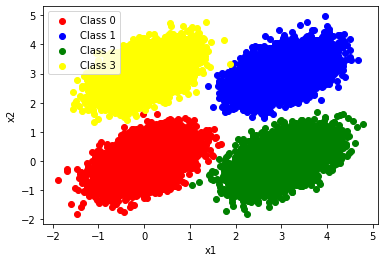

In [ ]:
# plotting data on scatter plot with different color for each class on scatter plot
plt.scatter(x=df[df['labels']==0]['x1'],y=df[df['labels']==0]['x2'], c='r',label='Class 0')
plt.scatter(x=df[df['labels']==1]['x1'],y=df[df['labels']==1]['x2'], c='blue',label='Class 1')
plt.scatter(x=df[df['labels']==2]['x1'],y=df[df['labels']==2]['x2'], c='green',label='Class 2')
plt.scatter(x=df[df['labels']==3]['x1'],y=df[df['labels']==3]['x2'], c='yellow',label='Class 3')
plt.legend()
plt.xlabel('x1')
plt.ylabel('x2')
plt.show()

## Task 2 - Training a model with more than 1 hidden layer and a non-linear activation function

In [ ]:
# Splitting the train dataset into train and validation set 
x_train1, x_val, y_train1, y_val = train_test_split(x_train, y_train, test_size = 0.33, random_state = 42)

In [ ]:
# importing tensorflow and keras sequential to create feedforward model
# importing dropout to apply regularization on the layers created
import tensorflow as tf
from keras.layers import Dropout
from keras.models import Sequential

In [ ]:
# here a keras sequential model is created with 2 layers and non-linear activation function 'relu'
# first argument 10 specifies number of nodes or neurons in a layer 
# a droput layer is created to apply regularization where it randomly drops the nodes from the layer based on the dropout rate passed
# dropout rate should be between 0 and 1
# the output layer and 4 nodes as our dataset has 4 different classes and it uses softmax function to convert logits created by model into a probablity notion and decide the class.
model = tf.keras.Sequential([
                             tf.keras.layers.Dense(10,activation='relu', input_shape=(2,)),  # input shape required
                             tf.keras.layers.Dropout(0.1),
                             tf.keras.layers.Dense(10,activation='relu'),
                             tf.keras.layers.Dropout(0.1),
                             tf.keras.layers.Dense(4,activation='softmax')
                             ])

In [ ]:
# the loss object created takes the resulted probability notion for each class and compare it actual label value and finds the loss
# it returns the loss value showing how bad the model is performing and our model should try to reduce this loss
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
def loss(model, x, y, training):
  predicted_y = model(x, training=training)
  return loss_object(y_true=y, y_pred=predicted_y)

In [ ]:
# creating a gradient descent function which is basically a derivative of loss function so internally loss function is called under the gradienttape function of tensorflow
# gradient tape function keeps track of all data and tape.gradient follows the backward propagation to derivate and a gradient or weights and loss value is returned.
def grad(model, inputs, targets):
  with tf.GradientTape() as tape:
    loss_value = loss(model, inputs, targets, training=True)
  return loss_value, tape.gradient(loss_value, model.trainable_variables)

In [ ]:
# here optimizer is created which updates the weights with the gradients generated from the model to reduce the loss and
# a learning rate shows the jump value for minima from one point to another  
# epoch is the number of times a model is called and weights are updated on each iteration.
num_epochs = 1001
optimizer = tf.keras.optimizers.SGD(learning_rate=0.3)
for epoch in range(num_epochs):
  # a gradient function is called which return a loss value and computed gradients
  loss_value, grads = grad(model, x_train1, y_train1)
  # here we apply optimizer to update weights on computed gradients
  optimizer.apply_gradients(zip(grads, model.trainable_variables))
  #here we print the loss value for each 200th iteration
  if epoch % 200 == 0:
    print("Epoch {}: Loss: {}".format(epoch, loss_value.numpy()))

Epoch 0: Loss: 1.3996912240982056
Epoch 200: Loss: 0.7960637807846069
Epoch 400: Loss: 0.7700433135032654
Epoch 600: Loss: 0.7643707394599915
Epoch 800: Loss: 0.7606273293495178
Epoch 1000: Loss: 0.7585409283638


## Task 3 - plotting the decision boundary for each class on a scatter plot 

In [ ]:
# creating a function to plot for data and model passed
def plot_decision_boundary(x,y, model):
    steps=1000
    cmap=plt.get_cmap('RdBu')
    # creating a mesh to plot the data
    xmin = x[:,0].min()-1
    xmax = x[:,0].max()+1
    ymin = x[:,1].min()-1
    ymax = x[:,1].max()+1
    x_span= np.linspace(xmin, xmax, steps)
    y_span= np.linspace(ymin, ymax, steps)
    xx, yy = np.meshgrid(x_span, y_span)
    # for each point in a mesh we assign a different color
    labels=(model.predict_classes(np.c_[xx.ravel(),yy.ravel()])).reshape(xx.shape)
    fig, ax= plt.subplots()
    # contourf is used to plot the decision boundry and fill the colors 
    ax.contourf(xx,yy,labels, cmap=cmap, alpha=0.3)
    # plotting the data points
    ax.scatter(x[:,0], x[:,1], c=y.ravel())
    return fig,ax

Instructions for updating:
Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).


(<Figure size 432x288 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7f325a082588>)

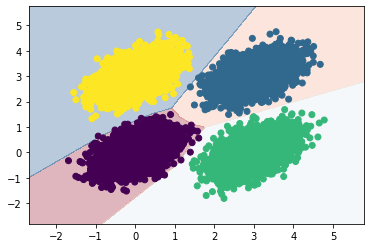

In [ ]:
# calling th plot function with train and test data and model fitted
plot_decision_boundary(x_train1, y_train1, model)

### it can be seen except for few points all data points are divided by their boundary correctly

## Task 4 - calculating train accuracy on validation set and test accuracy on test dataset

In [ ]:
# here we calculated accuracy on validation dataset
# a train accuracy objeact is created from keras accuracy metric where count and total is tracked by comparing predicted and acutual label 
train_accuracy = tf.keras.metrics.Accuracy()
# a logits variable is created which stores the probability notion generated by softmax function for each class by the model. 
logits = model(x_val, training=False)
# here out of all probability for all classes generated for each sample a class is selected for each sample whose probability is max
prediction = tf.argmax(logits, axis=1, output_type=tf.int32)
# comparing actual and predicted values and printing accuracy
train_accuracy(prediction, y_val)

print("validation dataset accuracy: {:.3%}".format(train_accuracy.result()))

validation dataset accuracy: 99.966%


In [ ]:
# same way test accuracy is also calculated
test_accuracy = tf.keras.metrics.Accuracy()
logits = model(x_test, training=False)
prediction = tf.argmax(logits, axis=1, output_type=tf.int32)
test_accuracy(prediction, y_test)

print("Test dataset accuracy: {:.3%}".format(test_accuracy.result()))

Test dataset accuracy: 99.924%


### Comparing results with different parameters with different model
### this is an example of bad model with bad parameters 

Epoch 0: Loss: 1.4274332523345947
Epoch 200: Loss: 1.2855169773101807
Epoch 400: Loss: 1.2769306898117065
Epoch 600: Loss: 1.2670332193374634
Epoch 800: Loss: 1.2677993774414062
Epoch 1000: Loss: 1.260438323020935


(<Figure size 432x288 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7f324fd3a2e8>)

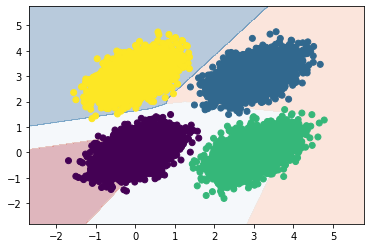

In [ ]:
# 
# similar model is created but with change in number of nodes in each layer and a increase in regularization which overfits the data
model1 = tf.keras.Sequential([
                             tf.keras.layers.Dense(3,activation='relu', input_shape=(2,)),  # input shape required
                             tf.keras.layers.Dense(3,activation='relu'),
                             tf.keras.layers.Dropout(0.8),
                             tf.keras.layers.Dense(4,activation='softmax')
                             ])
# here to calculate weights learning rate is increased that makes it difficult to find minima 
num_epochs = 1001
optimizer = tf.keras.optimizers.SGD(learning_rate=0.8)
for epoch in range(num_epochs):
  loss_value, grads = grad(model1, x_train1, y_train1)
  optimizer.apply_gradients(zip(grads, model1.trainable_variables))
  
  if epoch % 200 == 0:
    print("Epoch {}: Loss: {}".format(epoch, loss_value.numpy()))
# a decision boundary is plotted and it can be seen how bad the boundary is generated
plot_decision_boundary(x_train1, y_train1, model1)

In [ ]:
# calculating train accuracy on validation set and printing the result
train_accuracy1 = tf.keras.metrics.Accuracy()
logits1 = model1(x_val, training=False)
prediction1 = tf.argmax(logits1, axis=1, output_type=tf.int32)
train_accuracy1(prediction1, y_val)

print("validation set accuracy: {:.3%}".format(train_accuracy1.result()))

# calculating test accuracy on test dataset and printing the result
test_accuracy1 = tf.keras.metrics.Accuracy()
logits1 = model1(x_test, training=False)
prediction1 = tf.argmax(logits1, axis=1, output_type=tf.int32)
test_accuracy1(prediction1, y_test)

print("Test set accuracy: {:.3%}".format(test_accuracy1.result()))

validation set accuracy: 89.880%
Test set accuracy: 89.652%


## We can see from the result that this new model did not perform well clearly on accuracy and also finding the boundary for each class. Hence having right parametrs is very important in creating a model